### Introdução

Nesse caderno iremos aprender um pouco a gerar um classificador de imagem, usando uma rede neural do tipo Deconvulcional. Para isso utilizaremos o Dataset aberto MNIST, que é composto de 70000 imagens de números escritos à mão em escala de cinza. Nosso objetivo é criar um modelo que saiba classificar uma imagem em um dos possíveis dígitos (0,1,2,3,4,5,6,7,8,9). 

Para utilizar esse caderno certifique-se que você tem baixado todos os pacotes utilizados. Caso não, rode a célula a seguir sem os comentários para baixá-los.

In [2]:
# !pip install sklearn
# !pip install matplotlib
# !pip install tensorflow
# !pip install pandas
# !pip install numpy

### Importando Pacotes e Baixando Dataset

In [1]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

O dataset utilizado nesse tutorial pode ser baixado diretamente do tensorflow.
Outra opção é utilizar o disponível no site "https://www.kaggle.com/c/digit-recognizer" ou utilizando o comando "kaggle competitions download -c digit-recognizer" no prompt de comando (note que é necessario executar "pip install --upgrade kaggle" antes para poder chamar a função kaggle). Neste exemplo, as bases estão no folder "data".

Obs.: Não se assuste com os warnings.

In [2]:
# dataset externo (kaggle)

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Acessando o mesmo dataset através do tensorflow

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

W0821 18:25:53.024923 15808 deprecation.py:323] From <ipython-input-2-d2926d6a90fc>:9: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0821 18:25:53.028719 15808 deprecation.py:323] From C:\Users\rebecca.maria.murad\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0821 18:25:53.032730 15808 deprecation.py:323] From C:\Users\rebecca.maria.murad\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecate

Extracting MNIST_data\train-images-idx3-ubyte.gz


W0821 18:25:53.619320 15808 deprecation.py:323] From C:\Users\rebecca.maria.murad\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0821 18:25:53.723631 15808 deprecation.py:323] From C:\Users\rebecca.maria.murad\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [9]:
# Aqui iremos separar os datasets de treino e de teste:
x_train = mnist.train.images
y_train = mnist.train.labels

x_test = mnist.test.images
y_test = mnist.test.labels

### Explorando as bases 

Aqui podemos dar uma olhada no formato de cada uma das bases. Note que as bases x's possuem 784 colunas, o que significa que a imagem possui 784 pixels em escala cinza. Já as bases y's possuem apenas uma coluna que é o label (classe) de cada imagem. Por fim, a unica diferença entre as bases tipo "train" e "test" é o número de amostras.

In [51]:
print("Train shape:")
print(x_train.shape)
print(y_train.shape)
print("\nTest shape:")
print(x_test.shape)
print(y_test.shape)

Train shape:
(55000, 784)
(55000,)

Test shape:
(10000, 784)
(10000,)


Aqui iremos plotar uma das imagens para que possamos conhecer melhor a base. É importante observar que os dados estão dispostos em um único vetor, então será necessário aplicar a função "reshape" para vizualizar a imagem 2D.

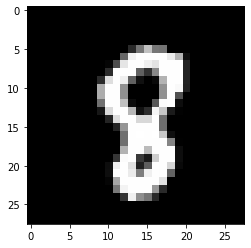

In [12]:
# Tente mudar o numero do índice para ver diferentes números na imagem
# Obs: também é possível variar entre as bases
rdm_img = x_train[25098]

rdm_img = rdm_img.reshape((28,28))
plt.imshow(rdm_img, cmap='gray')
plt.show()

### Construindo a rede DN (Deconvultional Neural Network)

Aqui iremos construir uma rede do tipo Deconvultional Neural Network (link: https://www.matthewzeiler.com/mattzeiler/deconvolutionalnetworks.pdf)

Se quiser se aprofundar mais nos tipos de redes neurais eu recomendo fortemente o site "http://www.asimovinstitute.org/neural-network-zoo/". Lá você verá que esse não é o tipo de rede mais recomendado para esse tipo de classificação, pois é pouco perfomático (lento para processar esse tipo de dado). O ideal seria utilizar uma rede do tipo convulsional, porém o dataset em questão é bem simples, o que permite essa abordagem.

Vale pontuar que estamos trabalhando com aprendizagem do tipo supervisionada, ou seja, nos sabemos quais são as classificações existentes e cada dado de treino está associado a uma classe.

Chamamos de features todas as variáveis que exceto a Classe. Elas são as nossas informações de entrada e é com elas que o algorítimo "aprenderá" a ler a imagem.

Um estimator é uma API de alto nível que, no caso, simplifica a criação de uma rede neural no tensorflow. Você pode encontrar mais detalhes em "https://www.tensorflow.org/guide/estimators". <div>
Os Parâmetros usados serão:
- feature_columns : Determina o formato das colunas de treino
- hidden_units : Número de neuronios por camada
- activation_fn : Função de ativação dos neurônios (https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0)
- optimizer : otimizador https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer com taxa de aprendizagem (https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/)
- n_classes : Número de classes da base (10 no caso)
- dropout : "Desliga" eventualmente uma porcentagem de neurônios, evitando overfitting
- model_dir : Diretório onde irá salvar os checkpoints do modelo

In [13]:
# Ensinando o tipo de imagem que estamos lidando
feature_columns = [tf.feature_column.numeric_column("x", shape=[28,28])]

In [14]:
# Gerando o Classificador
classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units = [256, 32],
    activation_fn = tf.nn.relu, # Função de ativação "relu"
    optimizer = tf.train.AdamOptimizer(1e-4),
    n_classes = 10,
    dropout = 0.1,
    model_dir = "./mnist_model"
)

Vamos definir uma função de input para ativar a rede. Os Parâmetros usados serão:
- x : features usadas para treino
- y : label
- num_epochs vs batch_size : sugiro ler https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 
- shuffle : Se queremos embaralhar a base ao treinar o dataset

In [15]:
# Input no formato de numpy_input_fn pq os dados estão em um numpy array
train_input_fun = tf.estimator.inputs.numpy_input_fn (
    x = {"x" : x_train},
    y = y_train.astype(np.int32),
    num_epochs = None,
    batch_size = 50,
    shuffle = True
)

### Treinando o modelo

Com todos os preparativos feitos, vamos simplesmente chamar a função "train_input_fun" no nosso classificador, elegendo o número de steps (que será o número de épocas de treino).

In [16]:
classifier.train(input_fn = train_input_fun, steps = 10000)

W0821 18:33:48.076384 15808 deprecation.py:323] From C:\Users\rebecca.maria.murad\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0821 18:33:48.106154 15808 deprecation.py:323] From C:\Users\rebecca.maria.murad\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\inputs\queues\feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0821 18:33:48.110506 15808 deprecation.py:323] From C:\Users\rebecca.maria.murad\AppData\Local\Continuum\anaconda3\lib\

### Testando e avaliando o modelo

Vamos Primeiro criar uma função input com os dados de teste semelhante a "train_input_fun". Os dados "x" e "y" agora são referentes aos dados de treino, porém vamos rodar o modelo apenas 1 vez e não será necessário embaralhar os dados. <div>
Depois iremos salvar os resultados da avaliação do modelo para comparar com as classes verdadeiras.

In [17]:
test_input_fun = tf.estimator.inputs.numpy_input_fn (
    x = {"x" : x_test},
    y = y_test.astype(np.int32),
    num_epochs = 1,
    shuffle = False
)

In [18]:
results = classifier.evaluate(input_fn = test_input_fun)

In [19]:
# Printando Resultados

# print(results)
print("Precisão do teste: {0:f}%\n".format(results["accuracy"] * 100))

Precisão do teste: 97.759998%



Vamos agora gerar a matriz confusão. Ela nos mostrará com detalhes o número de classificações corretas e equivocadas para cada uma das classes. Não recomendo utilizar quando há muitas classes envolvidas, porém é interessante observar que o ideal é que a maioria das classificações se concentrem na diagonal principal.

In [20]:
previsoes = classifier.predict(input_fn = test_input_fun)
previsoes = list(previsoes)
prev = []
for n in range(len(previsoes)):
    prev.append(previsoes[n]['class_ids'][0])

In [21]:
matrix = confusion_matrix(
    y_true = y_test,
    y_pred = prev
)

In [22]:
matrix

array([[ 969,    0,    2,    2,    0,    0,    2,    1,    2,    2],
       [   0, 1121,    3,    2,    0,    1,    4,    0,    4,    0],
       [   5,    1, 1010,    3,    1,    0,    2,    6,    4,    0],
       [   0,    0,    4,  997,    0,    2,    0,    3,    2,    2],
       [   0,    0,    6,    0,  963,    0,    2,    1,    2,    8],
       [   2,    0,    0,    9,    1,  869,    5,    1,    4,    1],
       [   5,    2,    2,    1,    6,    2,  940,    0,    0,    0],
       [   1,    6,    9,    3,    1,    0,    0,  998,    1,    9],
       [   3,    0,    4,    8,    4,    4,    4,    4,  937,    6],
       [   2,    3,    0,    8,   13,    2,    1,    8,    0,  972]],
      dtype=int64)

Espero que esse caderno tenha te ajudado a começar a mexer com classificação de imagens. Bons estudos e muito código pra você. <3 <3